# Implementing a GNN from Scratch with the Cora Dataset

In this notebook, we will implement a simple **Graph Neural Network (GNN)** from scratch using a fundamental learning rule:

$$
\mathbf{H} = \sigma(\tilde{A} \mathbf{X} \mathbf{W})
$$

where:
- $\mathbf{X}$ is the input feature matrix,
- $\mathbf{W}$ is a learnable weight matrix,
- $\sigma$ is a non-linear activation function (e.g., ReLU),
- $\tilde{A} = A + I$ is the adjacency matrix of the graph with added self-loops.

### Dataset: Cora

For the data we'll use, there's a dataset called the **Cora dataset**. The Cora dataset comprises **2708 scientific publications**, each classified into one of **seven distinct classes**. It features a citation network with **5429 links**. Every publication in the dataset is characterized by a **binary word vector**, which represents the absence (0) or presence (1) of certain words from a dictionary of **1433 unique terms**.

Our goal is to **classify each node** (publication) into one of these **seven classes**.

### Loading Cora with PyG

We will use **PyG (PyTorch Geometric)** to download and preprocess the Cora dataset.

> **PyTorch Geometric (PyG)** is a library built on top of PyTorch for deep learning on irregular structures like graphs. It provides easy-to-use APIs for working with graph data and implementing graph neural networks.

🔗 Official website: [https://pytorch-geometric.readthedocs.io](https://pytorch-geometric.readthedocs.io)


## Installing PyTorch Geometric (PyG)

To use PyTorch Geometric (PyG), you'll need to install both **PyTorch** and **PyG** with compatible versions.  
Consult the [Official Installation Instructions](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html)

### Step 1: Install PyTorch

Check your CUDA version (if using a GPU), then install the matching PyTorch version from the [official PyTorch website](https://pytorch.org/get-started/locally/), or run one of the following commands:

#### For CPU-only:
```bash
pip install torch torchvision torchaudio
```
#### For CUDA 11.8:

```bash
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```

### Step 2: Install PyG and its dependencies  
Use the following command to install PyG and its dependencies (replace `cu118` with your CUDA version if needed and `torch-2.2.0` with your version of PyTorch):  
```bash
pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
```

In [1]:
# Import the Planetoid class from PyG
from torch_geometric.datasets import Planetoid

# Then download the Cora dataset using this class
# We will donwload it in this directory (.)
dataset = Planetoid(root=".", name="Cora")

Processing...
Done!


In [2]:
# Cora only has one graph, can be accessed as follows
cora = dataset[0]

print(f'Dataset: {dataset.name}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {cora.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7


**The Cora dataset represents a citation network of scientific publications in the field of machine learning. Each node in the graph is a paper, and each edge is a citation link between papers. The goal is to predict the category (or class) of each paper based on its content and its citation relationships**

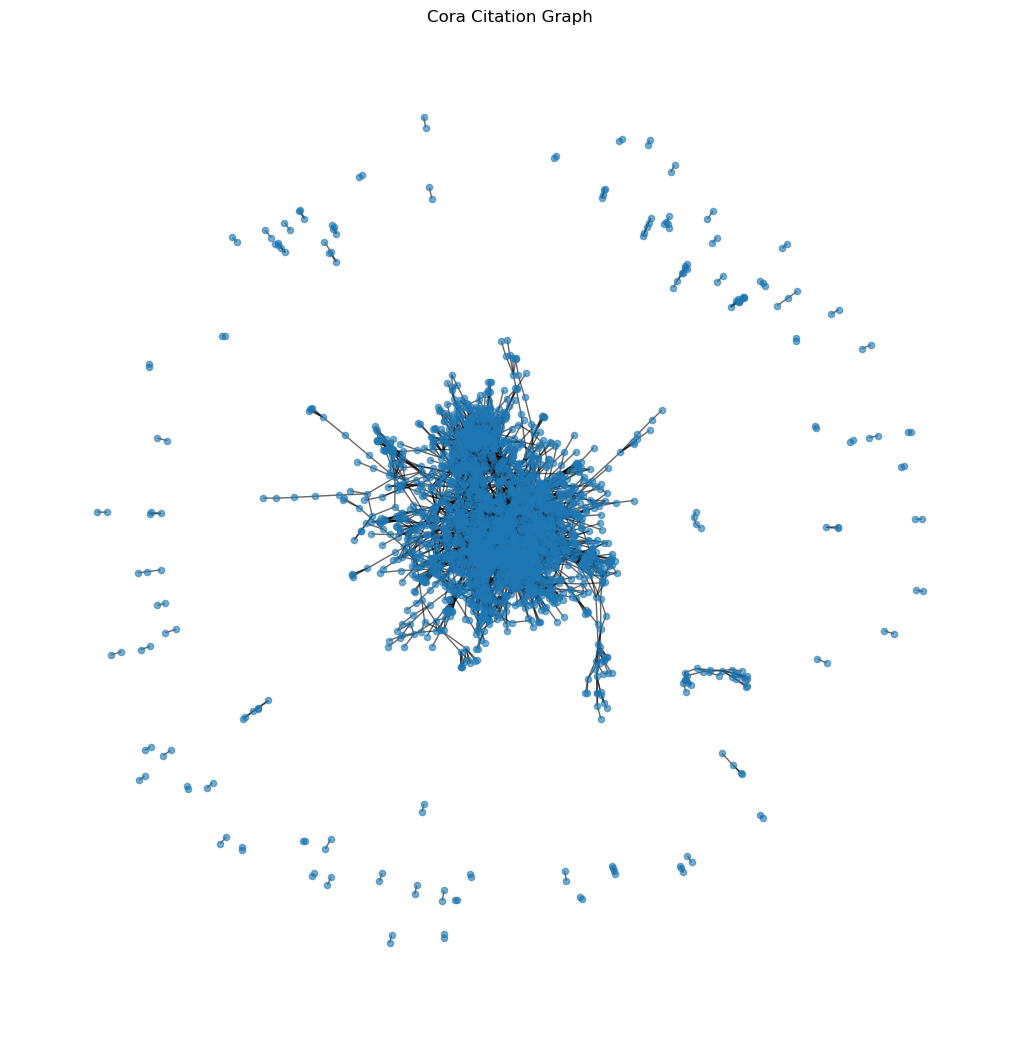

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert the PyG graph to a NetworkX graph
G = to_networkx(cora, to_undirected=True)

# Optional: set a layout for better visualization
pos = nx.spring_layout(G, seed=42)

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=20, alpha=0.6, with_labels=False)
plt.title("Cora Citation Graph")
plt.show()

## Step1: Let's train a very simple MLP for the task of node classification!  
**The goal is to predict the category (or class) of each paper based on its content and its citation relationships.**

In [4]:
# PyTorch imports
import torch
import torch.nn.functional as F

# A simple feed forward network for multiclass classification
class MLP(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, activation=torch.nn.ReLU):
        super().__init__()
        self.layer1 = torch.nn.Linear(in_features, hidden_features)
        self.layer2 = torch.nn.Linear(hidden_features, out_features)

        self.activation = activation()

    def forward(self, x):
        h = self.layer1(x)
        h = self.activation(h)
        h = self.layer2(h)
        out = F.log_softmax(h, dim=1)

        return out   

In [5]:
from sklearn.model_selection import train_test_split

# Extract the node features and the labels
X, y = cora.x.numpy(), cora.y.numpy()

# Split the data into train and test sets (80%, 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_data = {"X": torch.tensor(X_train, dtype=torch.float32), "y":torch.tensor(y_train, dtype=torch.long)}
test_data = {"X": torch.tensor(X_test, dtype=torch.float32), "y":torch.tensor(y_test, dtype=torch.long)}

In [20]:
import numpy as np
from tqdm import trange

# Define a simple training function
def fit(model, data, criterion, config):
    
    device    = config.device
    model     = model.to(device=device)
    # This is the first time we use Adam Optimizer: https://arxiv.org/abs/1412.6980
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    
    X = None
    if type(data["X"]) == torch.Tensor:
        X = data["X"].to(device)
    
    elif type(data["X"]) == dict:
        for key, value in data["X"].items():
            if isinstance(value, torch.Tensor):
                data["X"][key] = value.to(device)
                X = data["X"]       
        
    y = data["y"].to(device)

    # lists to keep track of losses and accuracies
    train_loss, train_acc = [], []

    # Training loop
    pbar = trange(config.max_epochs, unit=" epochs ")
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch}")
        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing X to the model
        y_pred = model(X)

        # Compute loss
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(y_pred.data, 1)    
        total = y.size(0)
        correct = (predicted == y).sum().item()
        accuracy = 100 * correct / total

        train_loss.append(loss.item())
        train_acc.append(accuracy)          

        # Print loss and accuracy
        pbar.set_postfix(loss=loss.item(), accuracy=accuracy)

    return {"train_loss": train_loss, 
            "train_acc": train_acc, 
            "iterations": np.arange(1, config.max_epochs+1)}

# Define a simple testing function
def test(model, data):
    model.eval()
    model = model.cpu()

    X = None
    if isinstance(data["X"], torch.Tensor):
        X = data["X"].cpu()
    
    elif type(data["X"]) == dict:
        for key, value in data["X"].items():
            if isinstance(value, torch.Tensor):
                data["X"][key] = value.cpu()
                X = data["X"]       
        
    y = data["y"].cpu()   

    yhat = model(X)
    # Calculate accuracy
    _, predicted = torch.max(yhat.data, 1)    
    total = y.size(0)
    correct = (predicted == y).sum().item()
    test_acc = 100 * correct / total
    
    print(f"Testing accuracy is {test_acc:.2f}%")
    
    return test_acc

### Traing the MLP

In [7]:
class Config:
    pass

config = Config()
config.device     = "cuda" if torch.cuda.is_available() else "cpu"
config.max_epochs = 100
config.lr         = 1e-3

mlp = MLP(in_features=X.shape[1], hidden_features=32, out_features=dataset.num_classes)

# Train the MLP
history = fit(model=mlp, data=train_data, criterion=torch.nn.CrossEntropyLoss(), config=config)

Epoch: 99: 100%|██████████| 100/100 [00:00<00:00, 145.39 epochs /s, accuracy=93.1, loss=0.531]


Testing accuracy is 71.96%


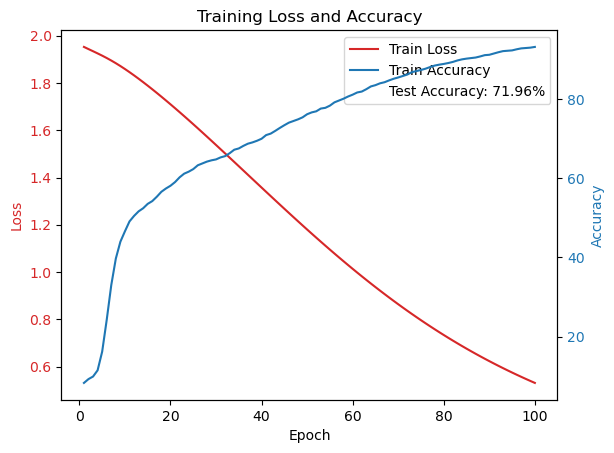

In [21]:
import matplotlib.patches as mpatches

# Let's plot the learning curve
fig, ax1 = plt.subplots()

# Evaluate the model on the test set
test_acc = test(model=mlp, data=test_data)

# Plot loss on ax1
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history["iterations"], history["train_loss"], color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Plot accuracy on ax2
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line2, = ax2.plot(history["iterations"], history["train_acc"], color=color, label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Create a fake legend entry for test accuracy
test_patch = mpatches.Patch(color='none', label=f'Test Accuracy: {test_acc:.2f}%')

# Combine all legend entries
lines = [line1, line2, test_patch]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Training Loss and Accuracy')
plt.show()

**The basic MLP model achieved a 72% accuracy on the test data. Now comes the thrilling part: training our custom-built GNN. The first thing we need is the **adjacency matrix**. In the cora dataset, this information is stored as an edge index, which is a way to store graph edges. The edge index is a 2-row matrix, where each column represents an edge. We'll convert this into a dense matrix using **PyG**. Once we have our adjacency matrix ready, we'll be all set to start building our own GNN,**

In [22]:
from torch_geometric.utils import to_dense_adj

# The adjacency matrix
A = to_dense_adj(cora.edge_index)[0]

# Now we should add the self-loops (Identity Matrix)
I = torch.eye(len(A))
A += I
print(A, A.shape)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]]) torch.Size([2708, 2708])


## Step 2: Now let's train our hand-made Graph Neural Network  

In [23]:
# A simple feed forward network for multiclass classification
class GNN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, activation=torch.nn.ReLU):
        super().__init__()
        # Learnable weights (W in h = WAX)
        self.W = torch.nn.Linear(in_features, hidden_features)
        self.classifier = torch.nn.Linear(hidden_features, out_features)

        self.activation = activation()

    def forward(self, inputs):
        X, A = inputs["node_features"], inputs["adjacency_matrix"]
        h = self.W(A@X)
        h = self.activation(h)
        h = self.classifier(h)
        out = F.log_softmax(h, dim=1)

        return out

In [24]:
# Inputs to our GNN model
gnn_inputs = {"X": {"node_features":cora.x, "adjacency_matrix":A}, "y":cora.y}

In [25]:
gnn = GNN(in_features=cora.x.shape[1], hidden_features=32, out_features=7)

# Train the GNN
history = fit(model=gnn, data=gnn_inputs, criterion=torch.nn.CrossEntropyLoss(), config=config)

Epoch: 99: 100%|██████████| 100/100 [00:00<00:00, 177.18 epochs /s, accuracy=95.6, loss=0.214]


Testing accuracy is 95.61%


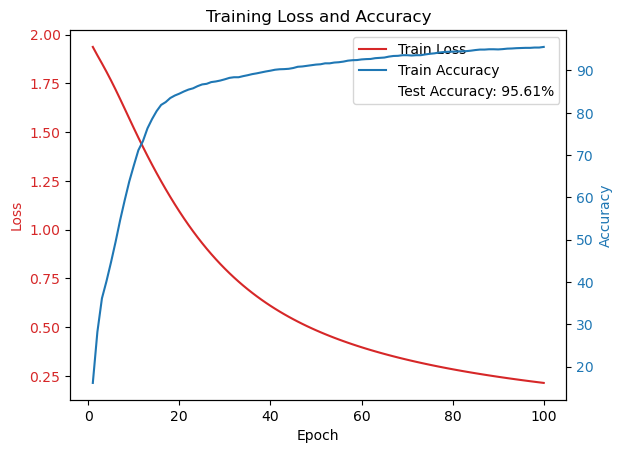

In [28]:
import matplotlib.patches as mpatches

# Let's plot the learning curve
fig, ax1 = plt.subplots()

# Evaluate the model on the test set
test_acc = test(model=gnn, data=gnn_inputs)

# Plot loss on ax1
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history["iterations"], history["train_loss"], color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Plot accuracy on ax2
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line2, = ax2.plot(history["iterations"], history["train_acc"], color=color, label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Create a fake legend entry for test accuracy
test_patch = mpatches.Patch(color='none', label=f'Test Accuracy: {test_acc:.2f}%')

# Combine all legend entries
lines = [line1, line2, test_patch]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Training Loss and Accuracy')
plt.show()

## Step 3: Now let's train a GCN model  

We will now train the **original Graph Convolutional Network (GCN)** as proposed by **Thomas Kipf and Max Welling** in their influential 2017 paper:

> *Semi-Supervised Classification with Graph Convolutional Networks*  
> [arXiv:1609.02907](https://arxiv.org/abs/1609.02907)

This model uses the following update rule for node representations:

$$
\mathbf{H}^{(l+1)} = \sigma\left( \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} \mathbf{H}^{(l)} \mathbf{W}^{(l)} \right)
$$

where:
- $\hat{A} = A + I$ is the adjacency matrix with self-loops,
- $\hat{D}$ is the degree matrix of $\hat{A}$,
- $\mathbf{W}^{(l)}$ are trainable weights,
- $\sigma$ is a non-linear activation (e.g., ReLU).

We will use the implementation provided by **PyTorch Geometric (PyG)**, which efficiently handles sparse graph data. The model will be trained on the **Cora dataset**, a citation network where each node is a publication and the task is to classify it into one of seven categories.

Let's begin training the GCN!

In [50]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# A simple 2-layer GCN for multiclass node classification
class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, activation=torch.nn.LeakyReLU):
        super().__init__()
        self.conv1 = GCNConv(in_features, hidden_features)
        self.conv2 = GCNConv(hidden_features, out_features)
        self.activation = activation()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index  # node features and graph structure

        h = self.conv1(x, edge_index)
        h = self.activation(h)
        h = self.conv2(h, edge_index)
        out = F.log_softmax(h, dim=1)

        return out

In [51]:
import numpy as np
from tqdm import trange

# Training function compatible with PyG GCN
def fit(model, data, criterion, config):
    device = config.device
    model = model.to(device)
    data = data.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    train_loss, train_acc = [], []

    pbar = trange(config.max_epochs, unit=" epochs ")
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch}")
        model.train()

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Accuracy on training set
        _, pred = out[data.train_mask].max(dim=1)
        correct = (pred == data.y[data.train_mask]).sum().item()
        acc = 100 * correct / data.train_mask.sum().item()

        train_loss.append(loss.item())
        train_acc.append(acc)
        pbar.set_postfix(loss=loss.item(), accuracy=acc)

    return {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "iterations": np.arange(1, config.max_epochs + 1)
    }

# Testing function compatible with PyG GCN
def test(model, data):
    model.eval()
    model = model.cpu()
    data = data.cpu()

    out = model(data)
    pred = out[data.test_mask].max(dim=1)[1]
    correct = (pred == data.y[data.test_mask]).sum().item()
    acc = 100 * correct / data.test_mask.sum().item()

    print(f"Testing accuracy is {acc:.2f}%")
    return acc

In [52]:
gcn = GCN(in_features=X.shape[1], hidden_features=64, out_features=dataset.num_classes)
# Train the GCN
history = fit(model=gcn, data=cora, criterion=torch.nn.CrossEntropyLoss(), config=config)

Epoch: 0:   0%|          | 0/100 [00:00<?, ? epochs /s]

Epoch: 99: 100%|██████████| 100/100 [00:00<00:00, 117.29 epochs /s, accuracy=100, loss=0.0787]


Testing accuracy is 79.60%


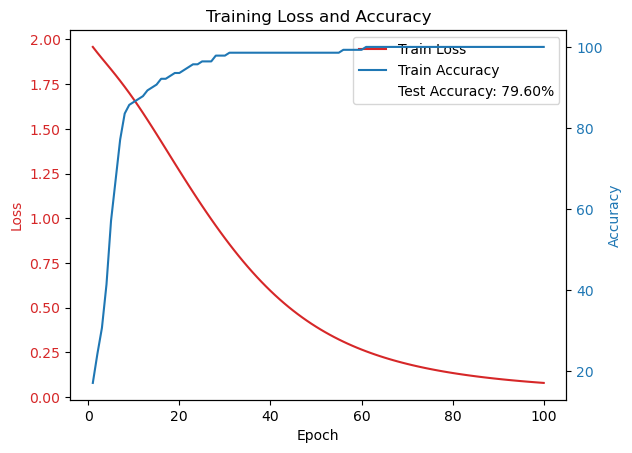

In [53]:
import matplotlib.patches as mpatches

# Let's plot the learning curve
fig, ax1 = plt.subplots()

# Evaluate the model on the test set
test_acc = test(model=gcn, data=cora)

# Plot loss on ax1
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history["iterations"], history["train_loss"], color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Plot accuracy on ax2
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line2, = ax2.plot(history["iterations"], history["train_acc"], color=color, label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Create a fake legend entry for test accuracy
test_patch = mpatches.Patch(color='none', label=f'Test Accuracy: {test_acc:.2f}%')

# Combine all legend entries
lines = [line1, line2, test_patch]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Training Loss and Accuracy')
plt.show()

## Bouns: Train a Graph Attention Network Using PyG

In [54]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, heads=8, activation=torch.nn.ELU):
        super().__init__()
        self.gat1 = GATConv(in_channels=in_features, 
                            out_channels=hidden_features, 
                            heads=heads, 
                            dropout=0.6)
        
        # Output layer: no heads concat, just averaging (set concat=False)
        self.gat2 = GATConv(in_channels=heads * hidden_features, 
                            out_channels=out_features, 
                            heads=1, 
                            concat=False, 
                            dropout=0.6)
        
        self.activation = activation()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.gat1(x, edge_index)
        x = self.activation(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [55]:
gat = GAT(in_features=X.shape[1], hidden_features=64, out_features=dataset.num_classes)
# Train the GAT
history = fit(model=gat, data=cora, criterion=torch.nn.CrossEntropyLoss(), config=config)

Epoch: 99: 100%|██████████| 100/100 [00:00<00:00, 100.21 epochs /s, accuracy=87.1, loss=0.37]


Testing accuracy is 81.40%


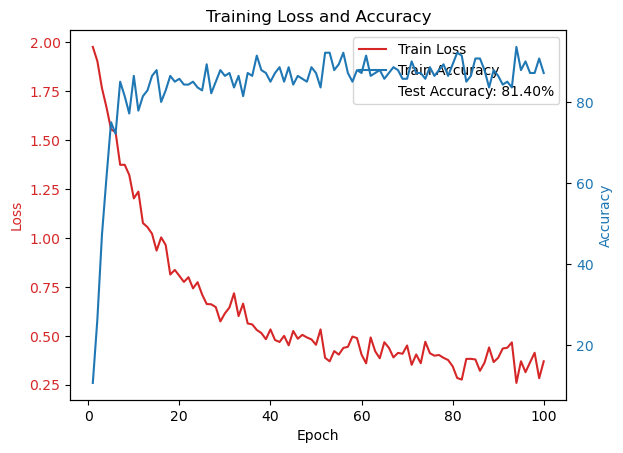

In [56]:
import matplotlib.patches as mpatches

# Let's plot the learning curve
fig, ax1 = plt.subplots()

# Evaluate the model on the test set
test_acc = test(model=gat, data=cora)

# Plot loss on ax1
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history["iterations"], history["train_loss"], color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Plot accuracy on ax2
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line2, = ax2.plot(history["iterations"], history["train_acc"], color=color, label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Create a fake legend entry for test accuracy
test_patch = mpatches.Patch(color='none', label=f'Test Accuracy: {test_acc:.2f}%')

# Combine all legend entries
lines = [line1, line2, test_patch]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Training Loss and Accuracy')
plt.show()